# Text classification with Pytorch

## Students

Carlos Eduardo Laschi de Oliveira

João Pedro Araújo Ferreira Campos

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to IMDB data - and then compare to models implemented in the previous TPs. 

In [1]:
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [3]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([7161114155999967329, 3486410841240711732, 3473175144428548195,
                         49,      94720879529776])
tensor([5])


In [4]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

In [5]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [6]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[-0.0842, -0.4938,  0.1443],
        [-0.1737,  0.4124, -0.1085]], requires_grad=True)
bias
Parameter containing:
tensor([-0.2707,  0.1222], requires_grad=True)
Initial loss:  0.9063856601715088
dL/dw:  tensor([[-0.0376,  0.0875,  0.3371],
        [ 0.2837,  0.3327,  0.0279]])
dL/db:  tensor([-0.0062,  0.1984])


In [7]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  0.902859628200531


In [8]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  0.8993940353393555


### Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [9]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue',
              'I walk through the wall']

toy_categories = [0, 0, 1, 0, 0, 0]

In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [11]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [12]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

6
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)
('i walk through the wall', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [13]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [14]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walked down down the boulevard', 'i walk through the wall'); labels: tensor([0, 0])
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the the avenue', 'i walked down the avenue'); labels: tensor([0, 0])
Epoch:1
Batch: ('i walked down the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walk down the the avenue', 'i walk through the wall'); labels: tensor([0, 0])
Batch: ('i walk down the city', 'i ran down the boulevard'); labels: tensor([0, 1])
Epoch:2
Batch: ('i ran down the boulevard', 'i walk down the the avenue'); labels: tensor([1, 0])
Batch: ('i walked down the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walked down down the boulevard', 'i walk through the wall'); labels: tensor([0, 0])


### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [15]:
import os
import sys

from torch.nn import functional as F
import torch
import torch.nn as nn

import numpy as np
import random

from nltk import word_tokenize
import re
from torch.nn.utils.rnn import pad_sequence

import torch.optim as optim

In [16]:
[*range(1, 10)]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [17]:
l = [*range(1, 10)]
random.sample(l, int(0.7 * len(l)))

[3, 6, 9, 7, 5, 2]

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/cadulaschi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

First, we get the filenames and the corresponding categories: 

In [19]:
from glob import glob
filenames_neg = sorted(glob(os.path.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'data', 'imdb1', 'pos', '*.txt')))
filenames = filenames_neg + filenames_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
categories = np.ones(len(filenames), dtype=np.int)
categories[:len(filenames_neg)] = 0.

print("%d documents" % len(filenames))

25000 documents


We will need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data. We need to implement a function that will help us split the data in three, according to proportions we give in input.

In [20]:
# Create a function allowing you to simply shuffle then split the filenames and categories into the desired
# proportions for a training, validation and testing set. 
def get_splits(x, y, splits):
    """
    The idea is to use an index list as reference:
    Indexes = [0 1 2 3 4 5 6 7 8 9]
    To shuffle it randomly:
    Indexes = [7 1 5 0 2 9 8 6 4 3]
    We need 'splits' to contain 2 values. Assuming those are = (0.8, 0.1), we'll have:
    Train_indexes = [7 1 5 0 2 9 8 6]
    Valid_indexes = [4]
    Test_indexes = [3]
    """
    # Create an index list and shuffle it - use the function random.shuffle
    # -- A compléter --
    indexes = list(range(len(x)))
    random.shuffle(indexes)
    
    # Find the two indexes we'll use to cut the lists from the splits
    # -- A compléter -- 
    train_size = int(splits[0] * len(x))
    valid_size = int(splits[1] * len(x))
    
    # Do the cutting (careful: you can't use a list as index for a list - this only works with tensors)
    # (you need to use list comprehensions - or go through numpy)
    train_x, train_y = [x[idx] for idx in indexes[:train_size]], [y[idx] for idx in indexes[:train_size]]# A compléter
    valid_x, valid_y = [x[idx] for idx in indexes[train_size:train_size+valid_size]], [y[idx] for idx in indexes[train_size:train_size+valid_size]] # A compléter
    test_x, test_y = [x[idx] for idx in indexes[train_size+valid_size:]], [y[idx] for idx in indexes[train_size+valid_size:]] # A compléter
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [21]:
# Choose the training, validation, testing splits
splits = (0.8, 0.1)
(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

In [22]:
#Checking each set length
print(len(train_f), len(train_c))
print(len(valid_f), len(valid_c))
print(len(test_f), len(test_c))

20000 20000
2500 2500
2500 2500


We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of path to the IMDB files in the training set: ```path_to_file```
- A list of the corresponding categories: ```categories```

We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [23]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [24]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [25]:
class TextClassificationDataset(Dataset):
    def __init__(self, paths_to_files, categories, vocab = None, max_length = 100, min_freq = 5):
        # Read all files and put the data in a list of strings
        self.data = [open(f, encoding="utf8").read() for f in paths_to_files]# A compléter
        
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We then need to tokenize the data .. 
        tokenized_data = [self.clean_and_tokenize(text) for text in self.data] # A compléter
        
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [self.indexed_transform(text) for text in tokenized_data] # A compléter
        
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(idx_list).to(device) for idx_list in indexed_data]# A compléter
        
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories).to(device)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tensor[:max_length] for tensor in tensor_data]# A compléter
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value = 0) # A compléter
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx]    
    
    def clean_and_tokenize(self, text):
        #lowercase
        text = text.lower()
        #removing numbers
        text = re.sub(r"[0-9]+", "", text)
        #removing words with 1 or 2 characters
        text = re.sub(r"\b\w{1,2}\b", "", text)
        
        tokens = [word for word in word_tokenize(text) if word.isalpha()]
        return tokens
    
    def indexed_transform(self, text):
        indexed_text = []
        
        for word in text:
            try:
                indexed_text.append(self.word2idx[word])
            except KeyError:
                indexed_text.append(self.word2idx.get(word, self.word2idx['UNK']))

        return indexed_text
    
   
    def build_vocab(self, corpus, count_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 !     
        """
        # A compléter
        frequency = {}
        for text in corpus:
            tokenized_text = self.clean_and_tokenize(text)
            
            for word in tokenized_text:
                try: 
                    frequency[word] += 1
                except KeyError:
                    frequency[word] = 1
                
        frequency = {key:value for key,value in frequency.items() if value >= count_threshold}  
        frequency['UNK'] = 0
        
        word_index = dict(zip(frequency.keys(), range(1, len(frequency)+1)))
        idx_word = dict(zip(range(1, len(frequency)+1), frequency.keys()))
        
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [26]:
training_dataset = TextClassificationDataset(train_f, train_c)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [27]:
valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

In [28]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [29]:
print(training_dataset[19999])

(tensor([ 2690,  6462, 25006,  5813,  4752,  7183,    82,  1263,  1014,  1296,
           13,  3067,    48,    60,    28,  1827,  1635,  1636,  2230,  9665,
        25006, 25006,    17,  3112,  3042,   326,   170,  2828,  6462,  1252,
         3591, 20734,  1296, 12284,  1447,    48, 25006, 25006, 25006,  2779,
         1225,    17,   483,    76, 15692,  8825, 14994,  3066,     7,    13,
           48,  2796,    17,   447, 25006, 12590,   838,   107,   463,  5368,
          285,    77, 25006,    13,  3425,  5830,    13,  9665,     7, 25006,
          622,  2929,     7, 17353,   218,    13,  8412,  2605,    69,   144,
          786,    13,  1655,    48,  5813,   776,    13,  1655,    48,    17,
         5393,    46,    13,  3067,    48,   622,   756,    17,  1820,    60],
       device='cuda:0'), tensor(1., device='cuda:0'))


In [30]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 100])
torch.Size([200])


### A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [31]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx = 0)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, 1)
        
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)
        x = torch.mean(x,dim=1,keepdim=False)
        #print(x.shape)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze(dim=1)
        return o

In [32]:
model = AveragingModel(300, len(training_word2idx))
model.to(device)
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

In [33]:
def positive(x):
    return torch.sigmoid(x) > 0.5

In [34]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute the loss 
        loss = criterion(pred, y)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()      
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        num_corrects = (positive(pred) & y.bool()).sum() + (~positive(pred) & ~y.bool()).sum()
        #print("tipo")
        #num_corrects = num_corrects.item()
        #print(type(num_corrects))
        acc = 100.0 * num_corrects/len(y)
        
        #if (i%20 == 0):
        #    print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

In [35]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred, y)
            num_corrects = (positive(pred) & y.bool()).sum() + (~positive(pred) & ~y.bool()).sum()
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [36]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = True):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        #print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [37]:
train_losses = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)

Beginning training...
Epoch 1 : Validation loss = 0.5206870096921921; Validation acc = 77.88
Epoch 2 : Validation loss = 0.3921226881444454; Validation acc = 83.28
Epoch 3 : Validation loss = 0.35492144361138345; Validation acc = 84.96
Epoch 4 : Validation loss = 0.34221557423472404; Validation acc = 86.04
Epoch 5 : Validation loss = 0.34271775841712954; Validation acc = 86.0
Early stopping.
Epoch 5 : Test loss = 0.32684551142156126; Test acc = 85.36


### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous TP:

In [38]:
#pip install gensim

In [39]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [40]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [41]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
#print(GloveEmbeddings[0])
# numpy array to tensor torch
GloveEmbeddings = torch.FloatTensor(GloveEmbeddings)

(25007, 300)


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

In [42]:
class PretrainedAveragingModel(nn.Module):
    def __init__(self, embedding_dim, freeze):
        super().__init__()
        #GloveEmbeddings = torch.FloatTensor(GloveEmbeddings)
        
        self.embeddings = nn.Embedding.from_pretrained(GloveEmbeddings, freeze = freeze, padding_idx = 0)
        #self.embeddings.requires_grad = fine_tune
        
        self.linear = nn.Linear(embedding_dim, 1)
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs)
        x = torch.mean(x,dim=1,keepdim=False)
        #print(x.shape)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze(dim=1)
        return o

In [43]:
model = PretrainedAveragingModel(GloveEmbeddings.shape[1], freeze = True)
model.to(device)

opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))

criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)

Beginning training...
Epoch 1 : Validation loss = 0.6308437937498093; Validation acc = 70.2
Epoch 2 : Validation loss = 0.5942491787672043; Validation acc = 71.72
Epoch 3 : Validation loss = 0.570458832681179; Validation acc = 73.6
Epoch 4 : Validation loss = 0.5527958726882934; Validation acc = 74.0
Epoch 5 : Validation loss = 0.5378268355131149; Validation acc = 75.2
Epoch 6 : Validation loss = 0.5287127673625946; Validation acc = 75.44
Epoch 7 : Validation loss = 0.5170970672369003; Validation acc = 76.64
Epoch 8 : Validation loss = 0.5097057223320007; Validation acc = 76.72
Epoch 9 : Validation loss = 0.502564643919468; Validation acc = 77.0
Epoch 10 : Validation loss = 0.4976903447508812; Validation acc = 77.2
Epoch 11 : Validation loss = 0.4918732529878616; Validation acc = 77.8
Epoch 12 : Validation loss = 0.4890039059519768; Validation acc = 77.56
Epoch 13 : Validation loss = 0.4840960708260536; Validation acc = 78.2
Epoch 14 : Validation loss = 0.480161626636982; Validation ac

In [44]:
model_tuned = PretrainedAveragingModel(GloveEmbeddings.shape[1], freeze = False)
model_tuned.to(device)
opt = optim.Adam(model_tuned.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses_tuned = experiment(model_tuned, opt, criterion, num_epochs = 10, early_stopping = True)

Beginning training...
Epoch 1 : Validation loss = 0.4760991477966309; Validation acc = 80.12
Epoch 2 : Validation loss = 0.36579019099473953; Validation acc = 84.88
Epoch 3 : Validation loss = 0.33901793889701365; Validation acc = 86.12
Epoch 4 : Validation loss = 0.3351267245411873; Validation acc = 85.88
Epoch 5 : Validation loss = 0.3435865257680416; Validation acc = 85.68
Early stopping.
Epoch 5 : Test loss = 0.33080379344522953; Test acc = 85.4


### Questions: 
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?

- Make hypothesis based on your intuition and the class on how
    - the number of documents (take only a portion of the 25.000 documents !)
    - the size of the vocabulary (change the minimum frequency of words to be taken in the vocabulary ! )
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
  
- Verify your hypothesis with experiments and analyze your results !

### Results with and without fine-tunng of embeddings imported from GloVe

In [45]:
import matplotlib.pyplot as plt
from scipy.signal import lfilter

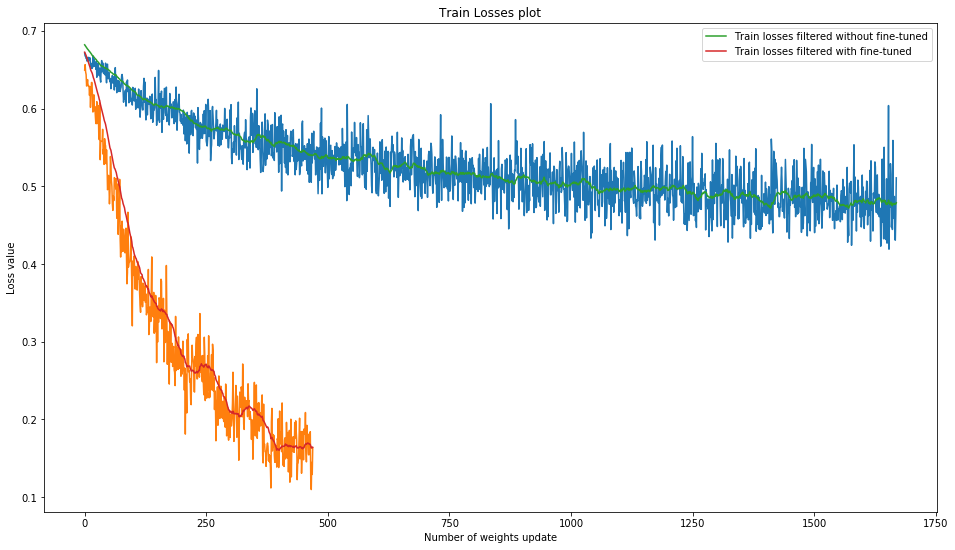

In [46]:
plt.figure(figsize=(16,9))

n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

plt.plot(train_losses[30:])
plt.plot(train_losses_tuned[30:])
plt.plot(lfilter(b, a, train_losses)[30:], label = 'Train losses filtered without fine-tuned')
plt.plot(lfilter(b, a, train_losses_tuned)[30:], label = 'Train losses filtered with fine-tuned')

plt.title("Train Losses plot")
plt.xlabel("Number of weights update")
plt.ylabel("Loss value")
plt.legend()
plt.show()

## Portion of documents

25%, 50% and 75%

In [47]:
def subsample_docs(k, splits):
    filenames = random.sample(filenames_neg, int(k*len(filenames_neg))) + random.sample(filenames_pos, int(k*len(filenames_neg)))
    categories = np.ones(len(filenames), dtype=np.int)
    categories[:int(k*len(filenames_neg))] = 0.

    print("%d documents" % len(filenames))
    
    return filenames, categories

In [48]:
train_losses_list = []

for k in [0.25, 0.50, 0.75]:
    print(str(100 * k) + " % of documents")
    
    filenames, categories = subsample_docs(k, splits)
    (train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

    training_dataset = TextClassificationDataset(train_f, train_c)
    training_word2idx, training_idx2word = training_dataset.get_vocab()

    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    
    print("Averaging Model")
    model = AveragingModel(300, len(training_word2idx))
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    
    train_losses_AM = experiment(model, opt, criterion, num_epochs = 100, early_stopping=True)
    
    print("Pretrained Averaging Model without fine tunning")
    model = PretrainedAveragingModel(GloveEmbeddings.shape[1], freeze = True)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_PAM = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)
    
    print("Pretrained Averaging Model with fine tunning")
    model = PretrainedAveragingModel(GloveEmbeddings.shape[1], freeze = False)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_PAM_tuned = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)
    
    print("\n")
        
    ##################
    
    train_losses_list.append([train_losses_AM, train_losses_PAM, train_losses_PAM_tuned])
    

25.0 % of documents
6250 documents
Averaging Model
Beginning training...
Epoch 1 : Validation loss = 0.6646037220954895; Validation acc = 65.92
Epoch 2 : Validation loss = 0.6276807808876037; Validation acc = 66.88
Epoch 3 : Validation loss = 0.5686326813697815; Validation acc = 74.08
Epoch 4 : Validation loss = 0.5089966213703155; Validation acc = 78.08
Epoch 5 : Validation loss = 0.46788612961769105; Validation acc = 77.92
Epoch 6 : Validation loss = 0.4419417929649353; Validation acc = 79.84
Epoch 7 : Validation loss = 0.4255046021938324; Validation acc = 80.16
Epoch 8 : Validation loss = 0.42127467691898346; Validation acc = 80.48
Epoch 9 : Validation loss = 0.41821596026420593; Validation acc = 80.64
Epoch 10 : Validation loss = 0.41883607327938077; Validation acc = 80.64
Early stopping.
Epoch 10 : Test loss = 0.43899613559246065; Test acc = 77.44
Pretrained Averaging Model without fine tunning
Beginning training...
Epoch 1 : Validation loss = 0.6908316159248352; Validation acc = 

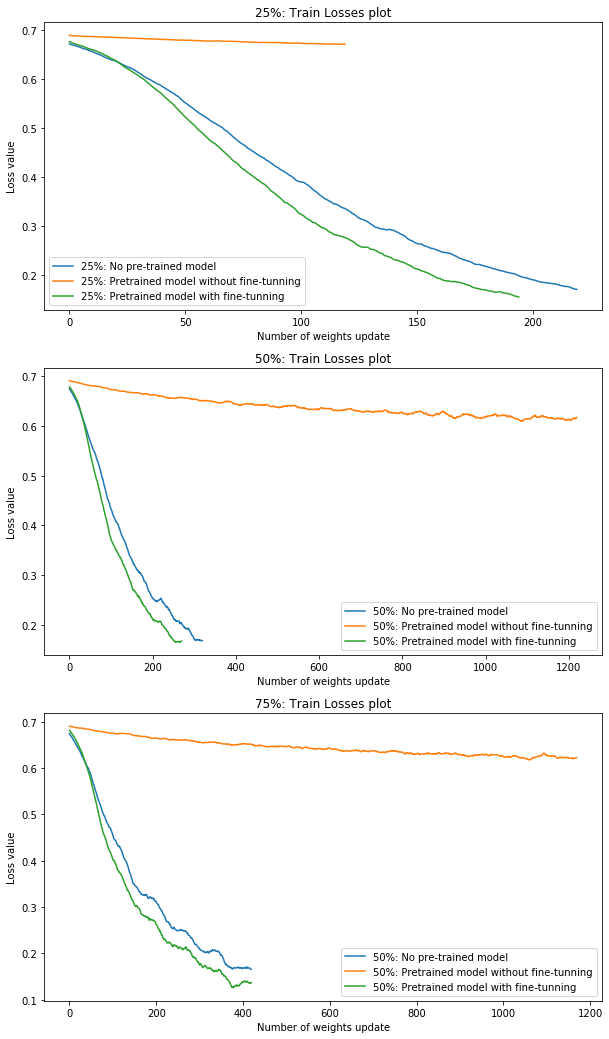

In [49]:
fig, axs = plt.subplots(3,1, figsize=(10,18))


n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

axs[0].plot(lfilter(b, a, train_losses_list[0][0])[30:], label = '25%: No pre-trained model')
axs[0].plot(lfilter(b, a, train_losses_list[0][1])[30:], label = '25%: Pretrained model without fine-tunning')
axs[0].plot(lfilter(b, a, train_losses_list[0][2])[30:], label = '25%: Pretrained model with fine-tunning')

axs[0].title.set_text('25%: Train Losses plot')
axs[0].set_xlabel("Number of weights update")
axs[0].set_ylabel("Loss value")
axs[0].legend()

axs[1].plot(lfilter(b, a, train_losses_list[1][0])[30:], label = '50%: No pre-trained model')
axs[1].plot(lfilter(b, a, train_losses_list[1][1])[30:], label = '50%: Pretrained model without fine-tunning')
axs[1].plot(lfilter(b, a, train_losses_list[1][2])[30:], label = '50%: Pretrained model with fine-tunning')

axs[1].title.set_text('50%: Train Losses plot')
axs[1].set_xlabel("Number of weights update")
axs[1].set_ylabel("Loss value")
axs[1].legend()

axs[2].plot(lfilter(b, a, train_losses_list[2][0])[30:], label = '50%: No pre-trained model')
axs[2].plot(lfilter(b, a, train_losses_list[2][1])[30:], label = '50%: Pretrained model without fine-tunning')
axs[2].plot(lfilter(b, a, train_losses_list[2][2])[30:], label = '50%: Pretrained model with fine-tunning')

axs[2].title.set_text('75%: Train Losses plot')
axs[2].set_xlabel("Number of weights update")
axs[2].set_ylabel("Loss value")
axs[2].legend()

plt.show()

### Answer: portion of documents 

For all portions, the best results were for Averaging and Petrained Averaging with fine tunning models. 

For a small number of documents (i.e. 25%), the no pre-training model do not have good results in terms of accuracy as it has for a big ammount of documents (i.e. 75%). In contrast, the pre-trained fine-tunning model got good results in any case, but always reaching better accuracies the bigger the quantity of date.

By the graphs we can see that the Pretrained fine-tunning model is slightly better than the no pre-trained model. 

This is explained by the fact that the pretrained model has no random weights and can be optimized even with a few ammount of data while the no pre-trained need more data to reach the same optimization. 

### Changing Minimum Frequency

In [50]:
filenames = filenames_neg + filenames_pos
categories = np.ones(len(filenames), dtype=np.int)
categories[:len(filenames_neg)] = 0.

print("%d documents" % len(filenames))

(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

train_losses_list = []

for freq in [7, 10, 15]:
    print("Minimum frequency = " + str(freq))

    training_dataset = TextClassificationDataset(train_f, train_c, min_freq = freq)
    training_word2idx, training_idx2word = training_dataset.get_vocab()

    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word), min_freq=freq)
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word), min_freq=freq)

    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)

    print("Averaging Model")
    model = AveragingModel(300, len(training_word2idx))
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_AM = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)

    print("Pretrained Averaging Model without fine tunning")
    model = PretrainedAveragingModel(GloveEmbeddings.shape[1], freeze = True)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_PAM = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)

    print("Pretrained Averaging Model with fine tunning")
    model = PretrainedAveragingModel(GloveEmbeddings.shape[1], freeze = False)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_PAM_tuned = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)

    print("\n")
    
    #################
    
    train_losses_list.append([train_losses_AM, train_losses_PAM, train_losses_PAM_tuned])


25000 documents
Minimum frequency = 7
Averaging Model
Beginning training...
Epoch 1 : Validation loss = 0.5065423652529717; Validation acc = 78.68
Epoch 2 : Validation loss = 0.38022218614816666; Validation acc = 83.52
Epoch 3 : Validation loss = 0.34236438542604447; Validation acc = 85.32
Epoch 4 : Validation loss = 0.33050303362309935; Validation acc = 85.68
Epoch 5 : Validation loss = 0.32957652837038043; Validation acc = 85.92
Epoch 6 : Validation loss = 0.3380342712253332; Validation acc = 85.8
Early stopping.
Epoch 6 : Test loss = 0.3519203864037991; Test acc = 85.0
Pretrained Averaging Model without fine tunning
Beginning training...
Epoch 1 : Validation loss = 0.672228142619133; Validation acc = 61.64
Epoch 2 : Validation loss = 0.6583336699008941; Validation acc = 65.2
Epoch 3 : Validation loss = 0.6480195963382721; Validation acc = 64.24
Epoch 4 : Validation loss = 0.6392849445343017; Validation acc = 65.28
Epoch 5 : Validation loss = 0.6327218466997147; Validation acc = 65.9

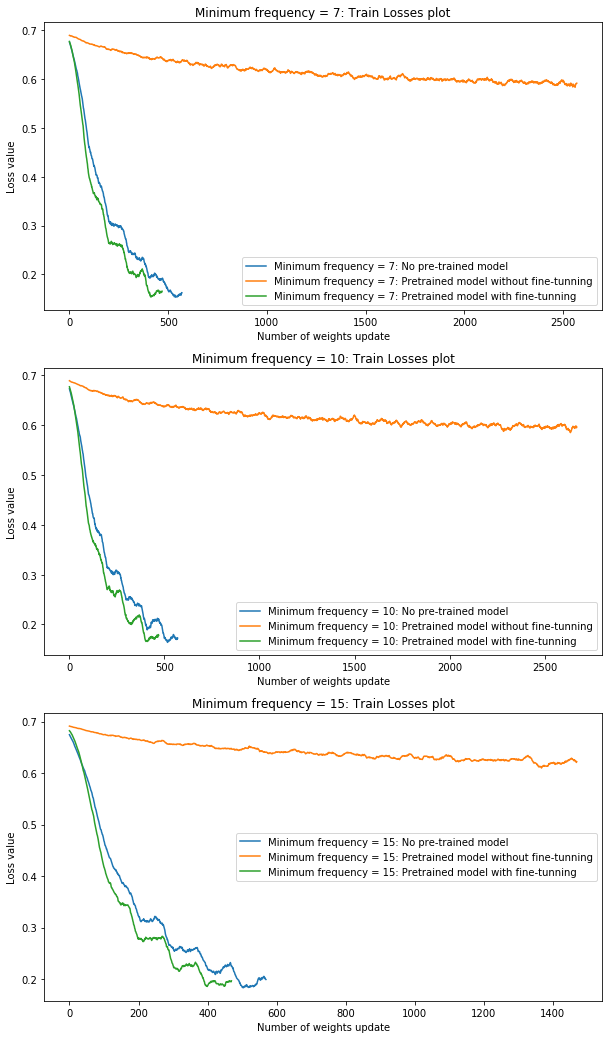

In [51]:
fig, axs = plt.subplots(3,1, figsize=(10,18))


n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

axs[0].plot(lfilter(b, a, train_losses_list[0][0])[30:], label = 'Minimum frequency = 7: No pre-trained model')
axs[0].plot(lfilter(b, a, train_losses_list[0][1])[30:], label = 'Minimum frequency = 7: Pretrained model without fine-tunning')
axs[0].plot(lfilter(b, a, train_losses_list[0][2])[30:], label = 'Minimum frequency = 7: Pretrained model with fine-tunning')

axs[0].title.set_text('Minimum frequency = 7: Train Losses plot')
axs[0].set_xlabel("Number of weights update")
axs[0].set_ylabel("Loss value")
axs[0].legend()

axs[1].plot(lfilter(b, a, train_losses_list[1][0])[30:], label = 'Minimum frequency = 10: No pre-trained model')
axs[1].plot(lfilter(b, a, train_losses_list[1][1])[30:], label = 'Minimum frequency = 10: Pretrained model without fine-tunning')
axs[1].plot(lfilter(b, a, train_losses_list[1][2])[30:], label = 'Minimum frequency = 10: Pretrained model with fine-tunning')

axs[1].title.set_text('Minimum frequency = 10: Train Losses plot')
axs[1].set_xlabel("Number of weights update")
axs[1].set_ylabel("Loss value")
axs[1].legend()

axs[2].plot(lfilter(b, a, train_losses_list[2][0])[30:], label = 'Minimum frequency = 15: No pre-trained model')
axs[2].plot(lfilter(b, a, train_losses_list[2][1])[30:], label = 'Minimum frequency = 15: Pretrained model without fine-tunning')
axs[2].plot(lfilter(b, a, train_losses_list[2][2])[30:], label = 'Minimum frequency = 15: Pretrained model with fine-tunning')

axs[2].title.set_text('Minimum frequency = 15: Train Losses plot')
axs[2].set_xlabel("Number of weights update")
axs[2].set_ylabel("Loss value")
axs[2].legend()

plt.show()

### Answer: Changing Minimum Frequency

First, it was not possible to decrease the minimum frequency because we always fot out of index problems. 

So, increasing the minimum frequency to 7, 10 and 15. As before, the pre-trained model without fine-tunning is still too far from the other with respect to the results. 

In addition, we can see that the higher minimum frequency, the lower the test accuracy. This is because of a dictionary with less words, the ones that appear too many times. 

Finally, by the graphics, it is interisting to see that the pretrained model with fine-tuning is always a bit better than the no pre-trained model with respect to the losses values. 

### LSTM Cells in pytorch

In [52]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
lstm.to(device)
inputs = [torch.randn(1, 3).to(device) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one lement)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3).to(device),
          torch.randn(1, 1, 3).to(device))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3).to(device), torch.randn(1, 1, 3).to(device))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.1909, -0.0461,  0.2105]],

        [[-0.1553, -0.2218, -0.0352]],

        [[-0.1954, -0.3702, -0.0355]],

        [[-0.1260, -0.1035, -0.0594]],

        [[-0.0937, -0.4947, -0.1805]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward>)
(tensor([[[-0.0937, -0.4947, -0.1805]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward>), tensor([[[-0.3588, -0.8050, -0.2839]]], device='cuda:0',
       grad_fn=<CudnnRnnBackward>))


### Creating our own LSTM Model

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

In [53]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocabulary_size=None, embeddings=None, fine_tuning=False):
        super().__init__()

        if embeddings is not None:
            #embeddings = torch.from_numpy(embeddings).float()
            self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, inputs):
        x = self.embeddings(inputs)

        hidden = (torch.randn(1, x.shape[0], self.hidden_dim).to(device), 
                    torch.randn(1, x.shape[0], self.hidden_dim).to(device))
        _, hidden = self.lstm(x, hidden)
        
        o = self.linear(hidden[0]).squeeze()
        return o

In [69]:
model = LSTMModel(300, 100, len(training_word2idx))
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1 : Validation loss = 0.6579919362068176; Validation acc = 61.54666666666667
Epoch 2 : Validation loss = 0.5894826134045918; Validation acc = 71.25333333333333
Epoch 3 : Validation loss = 0.6390921195348104; Validation acc = 67.94666666666667
Early stopping.
Epoch 3 : Test loss = 0.6351484068234762; Test acc = 68.16


## LSTMModel, GloVe, fine_tuning = False

In [68]:
model = LSTMModel(300, 100, embeddings=GloveEmbeddings)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1 : Validation loss = 0.6889531596501668; Validation acc = 52.48
Epoch 2 : Validation loss = 0.69425905307134; Validation acc = 49.92
Early stopping.
Epoch 2 : Test loss = 0.6944110759099325; Test acc = 52.693333333333335


## LSTMModel, GloVe, fine_tuning = True

In [67]:
model = LSTMModel(300, 100, embeddings=GloveEmbeddings, fine_tuning = True)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1 : Validation loss = 0.6939567144711812; Validation acc = 51.306666666666665
Epoch 2 : Validation loss = 0.5856330784161886; Validation acc = 70.24
Epoch 3 : Validation loss = 0.5410368140538534; Validation acc = 76.42666666666666
Epoch 4 : Validation loss = 0.5109213697910309; Validation acc = 78.61333333333333
Epoch 5 : Validation loss = 0.5756102861960729; Validation acc = 75.94666666666667
Early stopping.
Epoch 5 : Test loss = 0.6110191031297048; Test acc = 72.96


### And with a CNN ? 

In [57]:
class CNNModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size=None, embeddings=None, window_size: int = 16, filter_multiplier=64, fine_tuning=False):
        super().__init__()
        if embeddings is not None:
            #embeddings = torch.from_numpy(embeddings).float()
            self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=not fine_tuning, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        
        self.conv = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
        self.maxpool = nn.MaxPool1d(2)

        self.linear = nn.Linear(filter_multiplier, 1)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        
        x = self.conv(x.view(-1, x.shape[2], x.shape[1]))
        x = torch.relu(x).to(device)
        x = self.maxpool(x)
        
        x = x.mean(dim=2)
        o = self.linear(x).squeeze()
        return o

In [58]:
model = CNNModel(300, len(training_word2idx))
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1 : Validation loss = 0.4620194789767265; Validation acc = 77.64
Epoch 2 : Validation loss = 0.37891250774264335; Validation acc = 83.12
Epoch 3 : Validation loss = 0.427987914904952; Validation acc = 82.76
Early stopping.
Epoch 3 : Test loss = 0.43961068358272315; Test acc = 83.0


## CNN avec GloVe, fine_tuning = False

In [59]:
model = CNNModel(300, embeddings=GloveEmbeddings)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1 : Validation loss = 0.6825614005327225; Validation acc = 56.0
Epoch 2 : Validation loss = 0.6734223753213883; Validation acc = 58.96
Epoch 3 : Validation loss = 0.6670455241203308; Validation acc = 59.68
Epoch 4 : Validation loss = 0.69220733076334; Validation acc = 59.52
Early stopping.
Epoch 4 : Test loss = 0.7192379504442215; Test acc = 57.4


## CNN avec GloVe, fine_tuning = True

In [60]:
model = CNNModel(300, embeddings=GloveEmbeddings, fine_tuning = True)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1 : Validation loss = 0.36097401194274426; Validation acc = 84.2
Epoch 2 : Validation loss = 0.3648625833541155; Validation acc = 84.2
Early stopping.
Epoch 2 : Test loss = 0.3772551365941763; Test acc = 83.92


### Questions: 
- What do you see with a simple application of LSTMs and CNNs models ? 
- Similarly, make hypothesis based on your intuition and the class on how
    - the number of documents 
    - the size of the vocabulary 
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning) for the LSTM **or** CNN (and the CNN should be quite faster !) and verify your hypothesis with experiments and analyze your results !
- Present your results in a clear and synthetic way (table, figures) and be careful to experimental methodology. Notably, you should fix hyperparameters before making comparisons (you should use maximum length of sentences and batch sizes to accelerate training - similarly, using a SGD optimizer will be faster than Adam) ! 

In [61]:
train_losses_list = []

for k in [0.25, 0.50, 0.75]:
    print(str(100 * k) + " % of documents")
    
    filenames, categories = subsample_docs(k, splits)
    (train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

    training_dataset = TextClassificationDataset(train_f, train_c)
    training_word2idx, training_idx2word = training_dataset.get_vocab()

    valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
    test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

    training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
    test_dataloader = DataLoader(test_dataset, batch_size = 25)
    
    print("CNN Model")
    model = CNNModel(300, len(training_word2idx))
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    
    train_losses_AM = experiment(model, opt, criterion)
    
    print("Pretrained CNN Model without fine tunning")
    model = CNNModel(300, embeddings=GloveEmbeddings)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_PAM = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)
    
    print("Pretrained CNN Model with fine tunning")
    model = CNNModel(300, embeddings=GloveEmbeddings, fine_tuning=True)
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    train_losses_PAM_tuned = experiment(model, opt, criterion, num_epochs = 100, early_stopping = True)
    
    train_losses_list.append([train_losses_AM, train_losses_PAM, train_losses_PAM_tuned])
    
    print("\n")


25.0 % of documents
6250 documents
CNN Model
Beginning training...
Epoch 1 : Validation loss = 0.6912823605537415; Validation acc = 51.2
Epoch 2 : Validation loss = 0.6776189804077148; Validation acc = 60.96
Epoch 3 : Validation loss = 0.6649372100830078; Validation acc = 68.96
Epoch 4 : Validation loss = 0.7234398031234741; Validation acc = 72.8
Early stopping.
Epoch 4 : Test loss = 0.7750928783416748; Test acc = 66.4
Pretrained CNN Model without fine tunning
Beginning training...
Epoch 1 : Validation loss = 0.6922032427787781; Validation acc = 52.8
Epoch 2 : Validation loss = 0.7050731420516968; Validation acc = 52.96
Early stopping.
Epoch 2 : Test loss = 0.7280137014389038; Test acc = 50.24
Pretrained CNN Model with fine tunning
Beginning training...
Epoch 1 : Validation loss = 0.6502422428131104; Validation acc = 63.04
Epoch 2 : Validation loss = 0.5427760910987854; Validation acc = 73.6
Epoch 3 : Validation loss = 0.622662410736084; Validation acc = 75.36
Early stopping.
Epoch 3 :

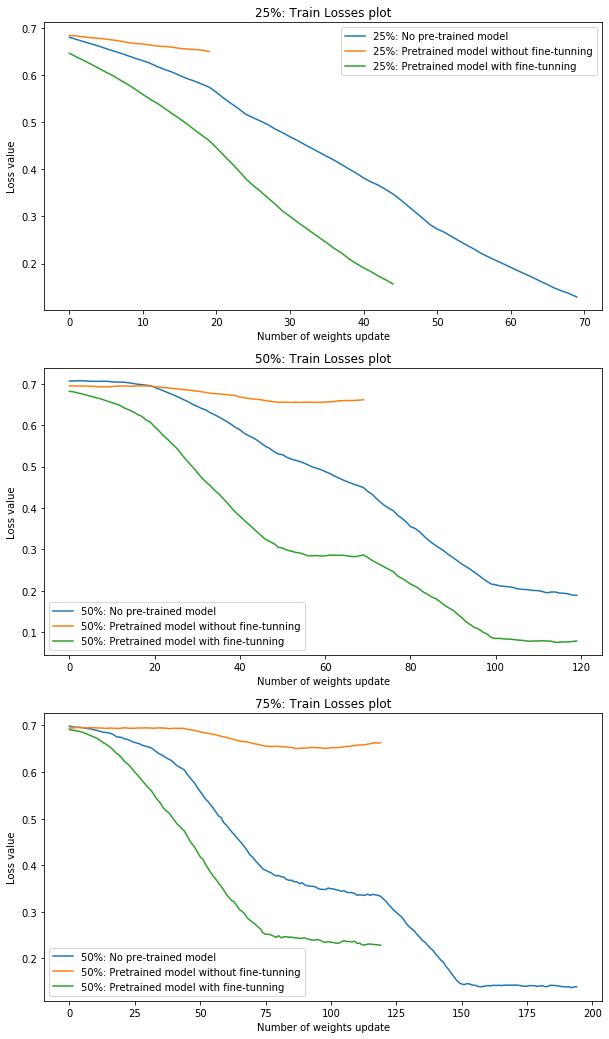

In [62]:
fig, axs = plt.subplots(3,1, figsize=(10,18))


n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

axs[0].plot(lfilter(b, a, train_losses_list[0][0])[30:], label = '25%: No pre-trained model')
axs[0].plot(lfilter(b, a, train_losses_list[0][1])[30:], label = '25%: Pretrained model without fine-tunning')
axs[0].plot(lfilter(b, a, train_losses_list[0][2])[30:], label = '25%: Pretrained model with fine-tunning')

axs[0].title.set_text('25%: Train Losses plot')
axs[0].set_xlabel("Number of weights update")
axs[0].set_ylabel("Loss value")
axs[0].legend()

axs[1].plot(lfilter(b, a, train_losses_list[1][0])[30:], label = '50%: No pre-trained model')
axs[1].plot(lfilter(b, a, train_losses_list[1][1])[30:], label = '50%: Pretrained model without fine-tunning')
axs[1].plot(lfilter(b, a, train_losses_list[1][2])[30:], label = '50%: Pretrained model with fine-tunning')

axs[1].title.set_text('50%: Train Losses plot')
axs[1].set_xlabel("Number of weights update")
axs[1].set_ylabel("Loss value")
axs[1].legend()

axs[2].plot(lfilter(b, a, train_losses_list[2][0])[30:], label = '50%: No pre-trained model')
axs[2].plot(lfilter(b, a, train_losses_list[2][1])[30:], label = '50%: Pretrained model without fine-tunning')
axs[2].plot(lfilter(b, a, train_losses_list[2][2])[30:], label = '50%: Pretrained model with fine-tunning')

axs[2].title.set_text('75%: Train Losses plot')
axs[2].set_xlabel("Number of weights update")
axs[2].set_ylabel("Loss value")
axs[2].legend()

plt.show()

We plot the training loss evolution for the three different CNN models. We notice that the model that does not use pretrained embedding achieves better results as we increase the number of input data. Using 50% of data, however, leads to a better performance from the model using GloVe, with tuning. It is clear that, for all cases, using GloVe can only achieve good results with tuning, which confirms our hypothesis that using an embedding made for our dataset is usually better than using a general one.

After training the LSTM model in the same three cases, we notice that it presents much more variance than we see with CNNs: LSTM prove to be a less reliable model to this task, also in contrast with the hipothesis that CNNs are less suitable for text classification due to its ihability to deal with long term dependencies.